In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from unidecode import unidecode
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import contractions

In [84]:
raw_philo_df = pd.read_csv('data/raw_askphilosophy_initial_scrape.csv',index_col = 'Unnamed: 0')
raw_psycho_df = pd.read_csv('data/raw_psychonaut_initial_scrape.csv', index_col = 'Unnamed: 0')

<ipython-input-84-11f592f853df>:1: DtypeWarning: Columns (1,2,9,10,11,12,13,14,18,20,21,22,23,24,25,27,28,32,33,34,40,45,46,55,61,64,65,68,73,74,83,84,85,86,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_philo_df = pd.read_csv('data/raw_askphilosophy_initial_scrape.csv',index_col = 'Unnamed: 0')
<ipython-input-84-11f592f853df>:2: DtypeWarning: Columns (1,2,5,7,9,10,11,12,13,14,18,20,21,22,23,24,25,27,29,30,31,32,33,34,39,42,46,47,58,61,71,74,75,77,78,79,80,85,87,88,96) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_psycho_df = pd.read_csv('data/raw_psychonaut_initial_scrape.csv', index_col = 'Unnamed: 0')


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,author_id,rte_mode,brand_safe,approved_at_utc,banned_at_utc,suggested_sort,view_count,author_created_utc,link_flair_css_class,distinguished
0,[],False,yellowskybluesun421,NaN,[],NaN,text,t2_pui71ti3,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,lelolguy,NaN,[],NaN,text,t2_4sv5s52,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Born2be99,NaN,[],NaN,text,t2_cp9xn7nq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Peter_Parkingmeter,NaN,[],NaN,text,t2_dddo4sz,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,FairCellist5556,NaN,[],NaN,text,t2_gpazn83n,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,thevardanian,NaN,NaN,NaN,NaN,t2_c343x,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.371615e+09,NaN,NaN
96,NaN,NaN,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,tunabricks,NaN,NaN,NaN,NaN,t2_eol36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.389033e+09,NaN,NaN


# Data Cleaning

Features of interest are the text based information: the post text (selfext) and the title of the post. 

To start, duplicate posts based on the title and the actual post text are removed. This will get rid of any extra information related to spammed posts, moderators posts, or any overall junk. Afterwards, replace any 'remove' or 'deleted' items found in the dataframe with NaN and drop. 

Any posts from the moderators will be removed to filter maintenance, redundancies, or regulatory information not related to the subreddit. The author feature can be used to locate and remove. 

Afterwards, the author feature is dropped as it is not needed for our text analysis, calculate the word count of each post, and then combine all text features into one. 

In [80]:
features = ['author', 'selftext', 'title']

#mods for askphilosophy
philo_mods = ['drinka40tonight', 'irontide','RealityApologist', 'Son_of_Sophroniscus', 'TheGrammarBolshevik', 
              'oneguy2008', 'ADefiniteDescription', 'MaceWumpus','BernardJOrtcutt', 'mediaisdelicious']

#mods for Psychonauts
psycho_mods = ['avatar3L1T3', 'ScienceRocketist', 'RoBoInSlowMo','AutoModerator','greatyellowshark']

In [81]:
#simplified datasets for each subreddit
philo_df = raw_philo_df[features].reset_index(drop=True)
psycho_df = raw_psycho_df[features].reset_index(drop=True)

In [82]:
psycho_df

,author,selftext,title
0,yellowskybluesun421,NaN,This outfit will make you think you're tripping
1,lelolguy,I'm fully committed to progressing through lif...,"Seriously, why can't we die when we want to?"
2,Born2be99,What is the trip on shrooms compared to LSD? W...,Mushroom vs LSD
3,Peter_Parkingmeter,Psychedelics are known to enhance connectivity...,"I have had a miniature, possibly deeply incorr..."
4,FairCellist5556,how many men suffered and suffer in silence be...,I can't believe how miserable and shitty toxic...
...,...,...,...
15085,thevardanian,"There is no hierarchy. There is no high, or lo...","I've been thinking about what a Psychonaut, or..."
15086,[deleted],NaN,What do you guys think about this? video[15:34]
15087,[deleted],NaN,BBC Documentary on Consciousness
15088,tunabricks,NaN,"The 7 Qualities to Look for in a Friend, Accor..."


## /r/askphilosophy cleaning

In [6]:
#drop dups
philo_df.drop_duplicates('selftext',inplace=True)
philo_df.drop_duplicates('title',inplace=True)

#replace removed or deleted information with NaNs
philo_df['selftext'].replace('[removed]',np.nan,inplace=True)
philo_df['selftext'].replace('[deleted]',np.nan,inplace=True)
philo_df['author'].replace('[deleted]',np.nan,inplace=True)

#drop all NaNs
philo_df.dropna(inplace=True)

#remove all posts by moderators
philo_df = philo_df[philo_df['author'].isin(philo_mods) == False]

#drop author columns now that moderators are removed
philo_df = philo_df.drop(columns='author')

#find the word count of each post
philo_df['post_length'] = philo_df['selftext'].apply(len)

#combine selftext and title into one column
philo_df['text'] = philo_df['selftext'] + philo_df['title']

#assign target value for askphilosophy to 1
philo_df['target'] = 1

#drop selftext and title 
philo_df = philo_df.drop(columns = ['selftext','title'])

In [7]:
philo_df.head()

,post_length,text,target
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1
1,175,Surely in just a absurd world like ours escapi...,1
3,82,"Of course not just physically, but what makes ...",1
4,1235,I consider myself an agnostic right now. I am ...,1
5,2033,Hello! I’m currently working on a term paper f...,1


In [8]:
philo_df.shape

(9158, 3)

## /r/Psychonaut cleaning

In [9]:
#drop dups
psycho_df.drop_duplicates('selftext',inplace=True)
psycho_df.drop_duplicates('title',inplace=True)

#replace removed or deleted information
psycho_df['selftext'].replace('[removed]',np.nan,inplace=True)
psycho_df['selftext'].replace('[deleted]',np.nan,inplace=True)
psycho_df['author'].replace('[deleted]',np.nan,inplace=True)

#drop all NaNs
psycho_df.dropna(inplace=True)

#remove all posts by moderators
psycho_df = psycho_df[psycho_df['author'].isin(psycho_mods) == False]

#drop author columns now that moderators are removed
psycho_df = psycho_df.drop(columns='author')

#find the word count of each post
psycho_df['post_length'] = psycho_df['selftext'].apply(len)

#combine selftext and title into one column
psycho_df['text'] = psycho_df['selftext'] + psycho_df['title']

#assign target for Psychonaut to 0
psycho_df['target'] = 0

#drop selftext and title 
psycho_df = psycho_df.drop(columns = ['selftext','title'])

In [10]:
psycho_df.head()

,post_length,text,target
1,991,I'm fully committed to progressing through lif...,0
2,77,What is the trip on shrooms compared to LSD? W...,0
3,1292,Psychedelics are known to enhance connectivity...,0
4,212,how many men suffered and suffer in silence be...,0
5,1224,Hey everyone. Sorry for the long post. My frie...,0


In [11]:
psycho_df.shape

(7010, 3)

## Merge Dataframe and Save

In [12]:
merged_df = pd.concat([philo_df,psycho_df])
#merged_df.to_csv('./data/philo_psycho_data.csv')

In [13]:
merged_df

,post_length,text,target
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1
1,175,Surely in just a absurd world like ours escapi...,1
3,82,"Of course not just physically, but what makes ...",1
4,1235,I consider myself an agnostic right now. I am ...,1
5,2033,Hello! I’m currently working on a term paper f...,1
...,...,...,...
11277,1071,"Among my favorites are these.\n\n""A man's suff...",0
11279,271,"If this is true, it means that we do not have ...",0
11283,4216,Since it doesn't seem like there is that many ...,0
11285,3819,"There is no hierarchy. There is no high, or lo...",0


## Intial Countvectorizer

The raw data from each subreddit can now be Count Vectorized in order to explore any basic observations before preprocessing.

In [87]:
philo_cvec = CountVectorizer(stop_words='english')
psycho_cvec = CountVectorizer(stop_words='english')
merged_cvec = CountVectorizer(stop_words='english')

In [15]:
philo_df_cvec = philo_cvec.fit_transform(philo_df['text'])
psycho_df_cvec = psycho_cvec.fit_transform(psycho_df['text'])
merged_df_cvec = merged_cvec.fit_transform(merged_df['text'])

In [16]:
philo_df_cvec = pd.DataFrame(philo_df_cvec.todense(),columns = philo_cvec.get_feature_names())
psycho_df_cvec = pd.DataFrame(psycho_df_cvec.todense(),columns = psycho_cvec.get_feature_names())
merged_df_cvec =  pd.DataFrame(merged_df_cvec.todense(),columns = merged_cvec.get_feature_names(),index = merged_df.index)

In [86]:
psycho_df_cvec

,00,000,0000,000000001,000mg,001,0016,001g,003,005,...,𝕥𝕠,𝕥𝕣𝕒𝕧𝕖𝕝𝕖𝕣,𝕨𝕖,𝕨𝕚𝕥𝕙,𝘍𝘌𝘈𝘛𝘜𝘙𝘌𝘚,𝘐𝘕𝘊𝘓𝘜𝘋𝘌,𝙄𝙉𝙏𝙀𝙍𝘿𝙄𝙈𝙀𝙉𝙎𝙄𝙊𝙉𝘼𝙇,𝙋𝙄𝙏,𝙎𝙏𝙊𝙋,𝟙𝟠
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7007,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preproccessing

Now that the data has been cleaned from nulls and missing values, the text can be structured and organized for better modeling. This will involve standardizing text, removing special characters, expanding contractions, tokenizing words, tagging the parts of speech, and lemmatize. Parts of speech are important for lemmatizing adequately and condensing similar words. This is a must to give accurate sums of words in each subreddit. 

### Unicode

Unicode conversion to remove any stylized text found within the reddit posts. Examples of this was seen during in intial count vectorization. 

In [17]:
def unidecoder(df,col_list):
    for col in col_list:
        unidecode_items = [unidecode(i) for i in df[col]]
        df['text'] = unidecode_items
    return df

In [18]:
unidecoder(merged_df,['text'])

,post_length,text,target
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1
1,175,Surely in just a absurd world like ours escapi...,1
3,82,"Of course not just physically, but what makes ...",1
4,1235,I consider myself an agnostic right now. I am ...,1
5,2033,Hello! I'm currently working on a term paper f...,1
...,...,...,...
11277,1071,"Among my favorites are these.\n\n""A man's suff...",0
11279,271,"If this is true, it means that we do not have ...",0
11283,4216,Since it doesn't seem like there is that many ...,0
11285,3819,"There is no hierarchy. There is no high, or lo...",0


### Contractions

Expanding any contractions to the respective word combinations. Helps with lemmatizing 

In [19]:
def contraction_fixer(df,col_list):
    for col in col_list:
        fixed_items = [contractions.fix(text) for text in df[col]]
        df['text'] = fixed_items
    return df

In [20]:
contraction_fixer(merged_df,['text'])

,post_length,text,target
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1
1,175,Surely in just a absurd world like ours escapi...,1
3,82,"Of course not just physically, but what makes ...",1
4,1235,I consider myself an agnostic right now. I am ...,1
5,2033,Hello! I am currently working on a term paper ...,1
...,...,...,...
11277,1071,"Among my favorites are these.\n\n""A man's suff...",0
11279,271,"If this is true, it means that we do not have ...",0
11283,4216,Since it does not seem like there is that many...,0
11285,3819,"There is no hierarchy. There is no high, or lo...",0


### Sentiment Analysis

Calculate sentiment analysis to use as another feature when running the classifier models. 

In [21]:
sid = SentimentIntensityAnalyzer()

In [22]:
for row in merged_df[['text']].iterrows():
    idx, values = row
    sentiments = sid.polarity_scores(values['text'])
    merged_df.loc[idx, 'neg'] = sentiments['neg']
    merged_df.loc[idx, 'pos'] = sentiments['pos']
    merged_df.loc[idx, 'neu'] = sentiments['neu']
    merged_df.loc[idx, 'compound'] = sentiments['compound']

In [23]:
merged_df.head()

,post_length,text,target,neg,pos,neu,compound
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1,0.090,0.076,0.834,-0.5913
1,175,Surely in just a absurd world like ours escapi...,1,0.046,0.179,0.775,0.9774
3,82,"Of course not just physically, but what makes ...",1,0.000,0.042,0.958,0.8397
4,1235,I consider myself an agnostic right now. I am ...,1,0.308,0.083,0.609,-0.9410
5,2033,Hello! I am currently working on a term paper ...,1,0.025,0.165,0.810,0.9879


## Tokenize, Tag POS, and Lemmatize

First, split up each word, remove any special characters and make all letter lower case. Tag the parts of speach via NLTK tagging and then convert to Wordnet POS tagging. From there, lemmatize each word and then join back after truncation.  

In [24]:
lemmatizer = WordNetLemmatizer()
def pos_tag_converter(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None

In [25]:
def lemmatize(sentence):
    token = RegexpTokenizer(r'[\w\'\']+')
    nltk_tag = nltk.pos_tag(token.tokenize(sentence.lower()))
    wordnet_tag = map(lambda x: (x[0], pos_tag_converter(x[1])), nltk_tag)
    
    lem_words = []
    for word, tag in wordnet_tag:
            if tag is None:                        
                 lem_words.append(word)
            else:
                lem_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lem_words)

In [26]:
merged_df['lemma_text'] = merged_df['text'].apply(lemmatize)

### Save preproccessed data

In [27]:
merged_df.to_csv('./data/preproccessed_data.csv')

# EDA

First, let's check the top 20 words in each subreddit. 

In [28]:
top_20_philo_df = pd.DataFrame(philo_df_cvec.sum().sort_values(ascending = False)).head(20)
top_20_philo_df.reset_index(inplace=True)

top_20_psycho_df = pd.DataFrame(psycho_df_cvec.sum().sort_values(ascending = False)).head(20)
top_20_psycho_df.reset_index(inplace=True)

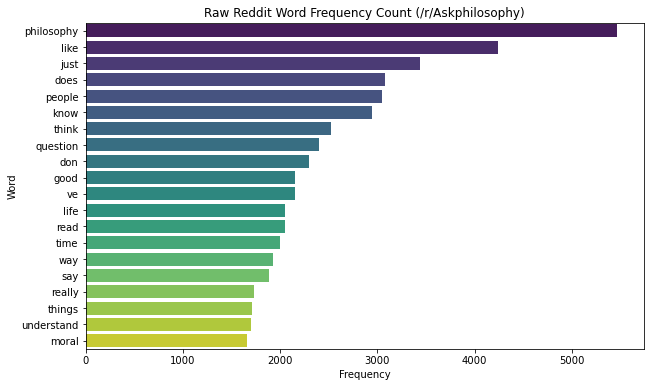

In [73]:
plt.figure(figsize=(10,6))
sns.barplot(data = top_20_philo_df,y=top_20_philo_df['index'],x=top_20_philo_df[0],orient='h',palette='viridis')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.title('Raw Reddit Word Frequency Count (/r/Askphilosophy)');
plt.savefig('./plots/initial_top_20_philo_df.jpeg',dpi=300, bbox_inches = "tight")

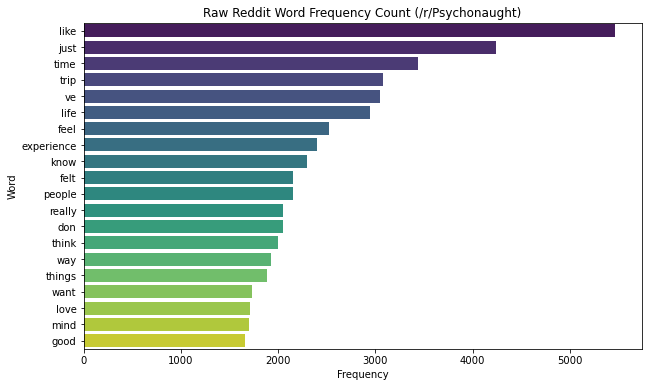

In [72]:
plt.figure(figsize=(10,6))
sns.barplot(data = top_20_psycho_df,y=top_20_psycho_df['index'],x=top_20_philo_df[0],orient='h',palette='viridis')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.title('Raw Reddit Word Frequency Count (/r/Psychonaut)')
plt.savefig('./plots/initial_top_20_psycho_df.jpeg',dpi=300, bbox_inches = "tight")

There are a lot of common words in both. We may need remove these to show the most important words with a different vectorizer later on.

Looking at the sentiment analysis data, there is a positive skew towards the positive sentiment in both subreddits. 

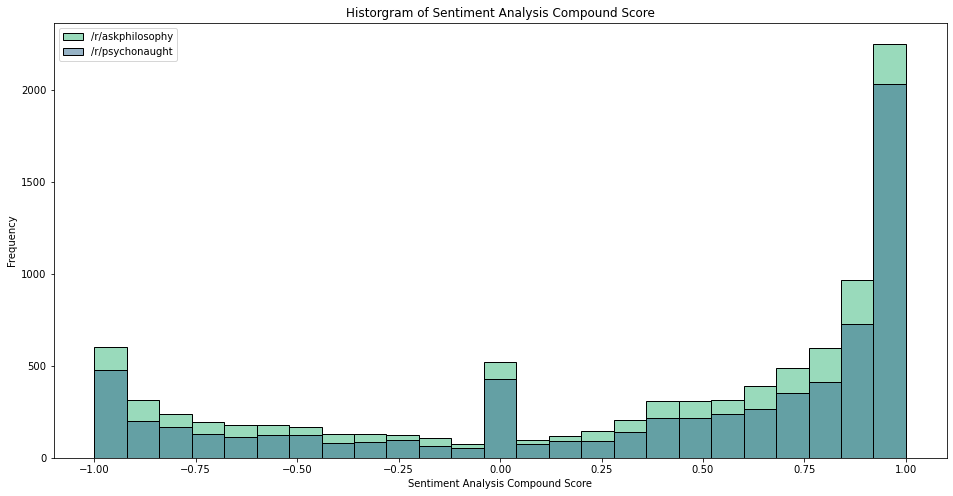

In [83]:
plt.figure(figsize=(16,8))
sns.histplot(data = merged_df,x='compound',hue='target',palette='viridis')
plt.ylabel('Frequency')
plt.xlabel('Sentiment Analysis Compound Score')
plt.legend(['/r/askphilosophy','/r/Psychonaut'])
plt.title('Historgram of Sentiment Analysis Compound Score')
plt.savefig('./plots/histogram_compoundscore.jpeg',dpi=300, bbox_inches = "tight")

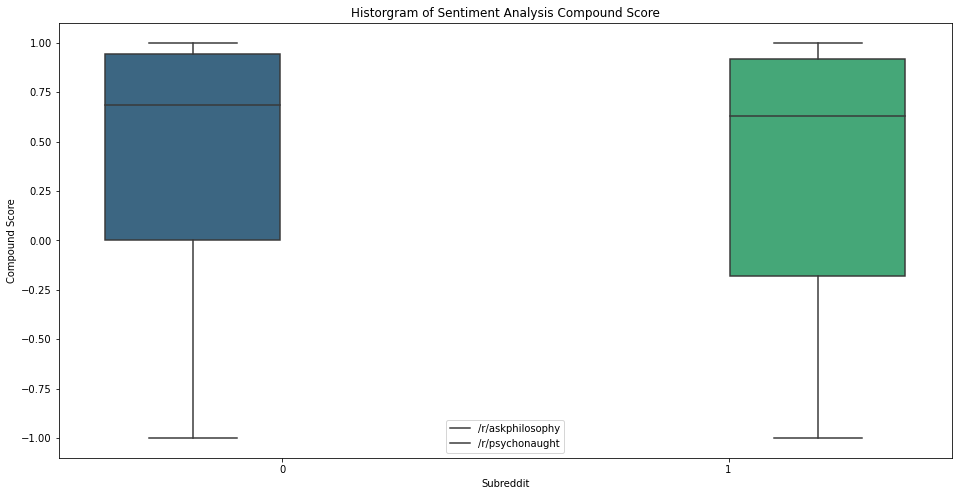

In [71]:
plt.figure(figsize=(16,8))
sns.boxplot(data = merged_df,x ='target', y='compound',hue='target',palette='viridis')
plt.xlabel('Subreddit')
plt.ylabel('Compound Score')
plt.legend(['/r/askphilosophy','/r/Psychonaut'],loc='lower center')
plt.title('Historgram of Sentiment Analysis Compound Score')
plt.savefig('./plots/boxplot_compoundscore.jpeg',dpi=300, bbox_inches = "tight")

Next, let's look at the post word count between each subreddit.

In [61]:
merged_df.groupby(by = 'target')['post_length'].describe().rename(index = {0:'Psychonaut',1:'askphilosophy'})

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
psychonaught,7010.0,1137.517832,1926.553370,1.0,237.0,540.0,1228.0,38959.0
askphilosophy,9158.0,687.292859,806.949541,1.0,238.0,452.0,843.0,18706.0


There are more total posts in the /r/philosohpy. This may have an affect on the classifaction since the data is slightly inbalanced. Mean values are different perhaps due to the large posts on /r/Psychonaut. Possible predictior feature when doing the classifaction modeling.

In [43]:
print('Philosophy Post Count below 500 Words:' , (merged_df.loc[(merged_df['target'] == 1) & (merged_df['post_length'] < 1200)]).shape[0])
print('Psychonaut Post Count below 500 Words:' ,(merged_df.loc[(merged_df['target'] == 0) & (merged_df['post_length'] < 1200)]).shape[0])

Philosophy Post Count below 500 Words: 7821
Psychonaught Post Count below 500 Words: 5213


Overall, the majority of posts are under 1200 words. Askphilosophy has a larger amount of smaller posts relative to Psychonaut but Psychonaut shows more posts of longer length with the trailing tail. Will use this feature in the modeling.

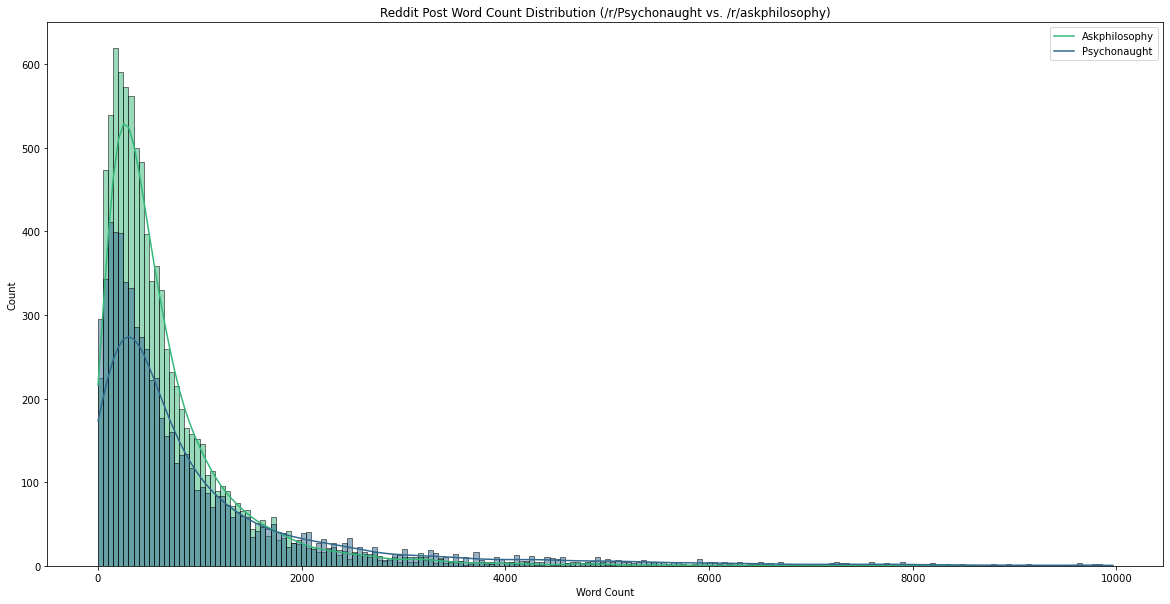

In [76]:
plt.figure(figsize=(20,10))

sns.histplot(merged_df.loc[merged_df['post_length'] < 10000]
    ,x='post_length',
    hue='target',
    palette='viridis',
    kde = True,
    bins=200)

plt.xlabel('Word Count')
plt.legend(('Askphilosophy','Psychonaut'))
plt.title('Reddit Post Word Count Distribution (/r/Psychonaut vs. /r/askphilosophy)')
plt.savefig('./plots/histogram_wordcount.jpeg',dpi=300, bbox_inches = "tight")

On to modeling...